### Code Hist.

 - CODE  
    &ensp; : Crawling - 특일 정보 조회 (KASI)

  - DATE  
    &ensp; 2023-11-29 Created  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1)   
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2)    
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 3)   
    
 - DESC  
    &ensp; : 전처리 - 한국지역난방공사 열판매량/열공급량   
    &emsp; 1) 결측치가 없어서, 그대로 사용  
    &emsp;&ensp;&ensp; 
    &emsp;&ensp;&ensp; (Crawl Code 없음)   
    &emsp; 2) 

 - DATA  
    &emsp; <"Input">  
    1) None (Input Dataset)  
    &emsp;- Period :   
    &emsp;- Interval : 

    &emsp; <"Output">  
    1) Hourly (관측소/년도별 출력)  
    &nbsp;df_data_cal.to_csv(data_dir + 'KASI_DATE_D_Final.csv', index = False, encoding='utf-8-sig')  
    &emsp;- Columns : ['YEAR', 'MONTH', 'DAY'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'dateKind', 'code_day_of_the_week', 'day_of_the_week'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'rest_YN', 'name_of_holiday', 'dist_from_holiday']
    &emsp;- Period :   
    &emsp;- Interval :  
    
    2) Daily (관측소/년도별 출력)  
    &nbsp;df_data_cal_24.to_csv(data_dir + 'KASI_DATE_H_Final.csv', index = False, encoding='utf-8-sig')  
    &emsp;- Columns : ['locdate', 'YEAR', 'MONTH', 'DAY'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'dateKind', 'code_day_of_the_week', 'day_of_the_week'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'rest_YN', 'name_of_holiday', 'dist_from_holiday'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'HOUR', 'MINUTE']
    &emsp;- Period :   
    &emsp;- Interval :  
    
    

 - Related Link  
    &ensp; : 

# 01. Code

## 01-01. Init

### 01-01-01. Init_Module Import

In [1]:
#region Basic_Import
## Basic
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import random
from pandas import DataFrame, Series

## Datetime
import time
import datetime as dt
from datetime import datetime, date, timedelta

import glob
from glob import glob
import requests
import json

## 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

from scipy import stats

## TSNE
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE

## 정규화
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
## Modeling, Model Training
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
## Model 평가
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score   # model.score   

## Excel/CSV
import openpyxl, xlrd

import urllib
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus

from selenium import webdriver
from selenium.webdriver.chrome.service import Service

from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

## For OLS
from statsmodels.formula.api import ols

## Init.
pd.options.display.float_format = '{:.10f}'.format
#endregion Basic_Import

In [2]:
## Import_DL
str_tar = "tf"
## For Torch
if str_tar == "torch":
    import torch
    import torch.nn as nn
    from torch.nn.utils import weight_norm
    print("Torch Imported")
## For TF
elif str_tar == "tf":
    import tensorflow as tf
    import tensorflow_addons as tfa
    print("Tensorflow Imported")
else:
    print("Error : Cannot be used except for Keywords")
    print(" : torch / tf")

Tensorflow Imported


In [3]:
## Import_Local (현재 프로그램에서 미사용)
from DEV_Common_Data_Datetime import create_col_ymdhm, create_col_datetime, create_df_dt, conv_midnight_24to00, create_col_weekdays #, validate_date, list_invalidDate, calc_df_dt
# from DEV_Common_Data_Preprocessing import resample_by_last, del_outlier_Usages
from DEV_Common_Data_Visualization import visualization_df
from DEV_KASI_Holiday import KASI_holiDay, KASI_restDay, KASI_anniDay
from DEV_KMA_Weather_ASOS import KMA_ASOS_DATA
from DEV_KDHC_Usage import KDHC_HEAT_Usage
from DEV_Common_Data_Analysis import print_desc_statistic

### 01-01-02. Config (Directory, Params)

In [4]:
## Init_config
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = "1"
random.seed(SEED)

In [5]:
## Define Todate str
str_now_ymd = pd.datetime.now().date()
str_now_y = pd.datetime.now().year
str_now_m = pd.datetime.now().month
str_now_d = pd.datetime.now().day
str_now_hr = pd.datetime.now().hour
str_now_min = pd.datetime.now().minute

print(pd.datetime.now())
print(str(str_now_y) + " / " + str(str_now_m)  + " / " + str(str_now_d))
print(str(str_now_hr) + " : " + str(str_now_min))

2023-11-30 12:40:21.380928
2023 / 11 / 30
12 : 40


In [10]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## 01-02. Data Load (df_raw)

### 01-02-01. KDHC Heat Usage

In [7]:
# Define data root directory
str_dir_kdhcHeat = "./data_Energy_KDHC_National_Heat/"
print(os.listdir(str_dir_kdhcHeat))

df_kdhc_heat = pd.read_csv(str_dir_kdhcHeat + 'KDHC_COMB_HEATxWEATHER_2019-2022.csv', index_col = 0)
df_kdhc_heat

['DATA_KDHC_Heat_Provide_Cheongju_2010_2021.csv', 'DATA_KDHC_Heat_Provide_Cheongju_2010_2021_1st_Check.csv', 'DATA_KDHC_Heat_Provide_Sejong_2014_2018.csv', 'DATA_KDHC_Heat_Provide_Sejong_2014_2018_1st_Check.csv', 'DATA_KDHC_Heat_Sell_Branch_201910_202109.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_complete_analysis.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_linearReg.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_mean_imp.csv', 'KDHC_NATIONAL_HEAT_hr.csv', 'KDHC_NATIONAL_HEAT_RAW_hr.csv']


,METER_DATE,day_of_the_week,YEAR,MONTH,DAY,HOUR,MINUTE,code_day_of_the_week,rest_YN,dist_from_holiday,...,SUWON,HWASUNG,DONGTAN,PYONGTAEK,CHEONGJU,SEJONG,KIMHAE,DAEGU,YANGSAN,GWANGJU_JEONNAM
0,2019-10-01 01:00:00,Tuesday,2019,10,1,1,0,1,0,2,...,26.0000000000,11.0000000000,21,0.5000000000,16,18.0000000000,8,19.0000000000,10,3
1,2019-10-01 01:00:00,Tuesday,2019,10,1,1,0,1,0,2,...,26.0000000000,11.0000000000,21,0.5000000000,16,18.0000000000,8,19.0000000000,10,3
2,2019-10-01 02:00:00,Tuesday,2019,10,1,2,0,1,0,2,...,29.0000000000,12.0000000000,16,0.5000000000,13,15.0000000000,7,16.0000000000,9,2
3,2019-10-01 02:00:00,Tuesday,2019,10,1,2,0,1,0,2,...,29.0000000000,12.0000000000,16,0.5000000000,13,15.0000000000,7,16.0000000000,9,2
4,2019-10-01 03:00:00,Tuesday,2019,10,1,3,0,1,0,2,...,33.0000000000,12.0000000000,14,0.5000000000,10,15.0000000000,7,15.0000000000,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27298,2022-09-30 20:00:00,Friday,2022,9,30,20,0,4,0,1,...,73.0000000000,39.0000000000,61,12.0000000000,36,44.0000000000,12,30.0000000000,18,6
27299,2022-09-30 21:00:00,Friday,2022,9,30,21,0,4,0,1,...,71.0000000000,36.0000000000,55,4.0000000000,30,44.0000000000,11,35.0000000000,22,5
27300,2022-09-30 22:00:00,Friday,2022,9,30,22,0,4,0,1,...,65.0000000000,29.0000000000,45,2.0000000000,27,43.0000000000,12,32.0000000000,22,6
27301,2022-09-30 23:00:00,Friday,2022,9,30,23,0,4,0,1,...,64.0000000000,25.0000000000,32,3.0000000000,25,40.0000000000,11,34.0000000000,22,6


In [8]:
df_kdhc_heat = create_col_ymdhm(df_kdhc_heat, 'METER_DATE')
df_kdhc_heat = create_col_weekdays(df_kdhc_heat, 'METER_DATE')

# list_col = np.delete(df_kdhc_heat.columns.values, 0, 0)
list_col = ['PAJU', 'GOYANG', 'SAMSONG'
            , 'JOONGANG'
            , 'KANGNAM'
            , 'PANGYO', 'BUNDANG', 'YONGIN', 'GWANGGYO', 'SUWON', 'HWASUNG', 'DONGTAN'
            , 'PYONGTAEK', 'CHEONGJU', 'SEJONG'
            , 'KIMHAE', 'DAEGU', 'YANGSAN'
            , 'GWANGJU_JEONNAM']

# for col in list_col:
#     visualization_df(df_kdhc_heat, col)

### 01-03. Analysis Correlation

In [9]:
df_kdhc_heat.columns

Index(['METER_DATE', 'day_of_the_week', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'MINUTE', 'code_day_of_the_week', 'rest_YN', 'dist_from_holiday',
       'temp_outdoor', 'temp_dew_point', 'temp_ground', 'humidity', 'rainfall',
       'snowfall', 'snowfall_3hr', 'wind_speed', 'wind_direction',
       'pressure_vapor', 'pressure_area', 'pressure_sea', 'sunshine',
       'solar_radiation', 'cloud_total', 'cloud_midlow', 'visual_range',
       'PAJU', 'GOYANG', 'SAMSONG', 'JOONGANG', 'KANGNAM', 'PANGYO', 'BUNDANG',
       'YONGIN', 'GWANGGYO', 'SUWON', 'HWASUNG', 'DONGTAN', 'PYONGTAEK',
       'CHEONGJU', 'SEJONG', 'KIMHAE', 'DAEGU', 'YANGSAN', 'GWANGJU_JEONNAM'],
      dtype='object')

In [10]:
col_tar = 'PAJU'

list_col_x = [['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week', 'day_of_the_week', 'rest_YN', 'dist_from_holiday'
               , 'HOUR', 'MINUTE'
               , 'temp_outdoor', 'temp_dew_point', 'temp_ground'
               , 'humidity'
               , 'rainfall'
               , 'snowfall', 'snowfall_3hr'
               , 'wind_speed', 'wind_direction'
               , 'pressure_vapor', 'pressure_area', 'pressure_sea'
               , 'sunshine', 'solar_radiation'
               , 'cloud_total', 'cloud_midlow'
               , 'visual_range'
            #    , 'PAJU'
               , 'GOYANG', 'SAMSONG'
               , 'JOONGANG'
               , 'KANGNAM'
               , 'PANGYO', 'BUNDANG', 'YONGIN', 'GWANGGYO', 'SUWON', 'HWASUNG', 'DONGTAN'
               , 'PYONGTAEK', 'CHEONGJU', 'SEJONG'
               , 'KIMHAE', 'DAEGU', 'YANGSAN'
               , 'GWANGJU_JEONNAM']]

# df_x = df_kdhc_heat.drop(columns = col_tar, axis = 1)
# df_y = df_kdhc_heat[col_tar]

df_raw_residual = pd.DataFrame(df_kdhc_heat)
model = ols('PAJU ~ dist_from_holiday + GOYANG + SAMSONG', data = df_raw_residual)
# model = ols('PAJU ~ YEAR+MONTH+HOUR+code_day_of_the_week+day_of_the_week+rest_YN+dist_from_holiday+temp_outdoor+temp_dew_point+temp_ground+humidity+rainfall+snowfall+snowfall_3hr+wind_speed+wind_direction+pressure_vapor+pressure_area+pressure_sea+sunshine+solar_radiation+cloud_total+cloud_midlow+visual_range+GOYANG+SAMSONG', data = df_raw_residual)
result = model.fit()
print(result.summary())

print_desc_statistic(df_kdhc_heat, 'PAJU')

ValueError: mismatch between column_names and columns coded by given terms

In [11]:
## 상관관계 분석
## 상관관계 변수 생성
df_corr = df_kdhc_heat.corr()
df_corr.corr()

,YEAR,MONTH,DAY,HOUR,MINUTE,code_day_of_the_week,temp_outdoor,temp_dew_point,temp_ground,humidity,rainfall,snowfall,snowfall_3hr,wind_speed,wind_direction,pressure_vapor,pressure_area,pressure_sea,sunshine,solar_radiation,cloud_total,cloud_midlow,visual_range,PAJU,GOYANG,SAMSONG,JOONGANG,KANGNAM,PANGYO,BUNDANG,YONGIN,GWANGGYO,SUWON,HWASUNG,DONGTAN,PYONGTAEK,CHEONGJU,SEJONG,KIMHAE,DAEGU,YANGSAN,GWANGJU_JEONNAM
YEAR,1.0000000000,-0.4189605851,0.0068548257,0.0844419605,NaN,-0.0661959184,0.1266366921,0.0872055861,0.1426873683,-0.1488110439,0.0372140510,0.0107426441,-0.0301297300,0.1811093218,0.0300285043,0.1234414976,-0.2027532275,-0.2006716093,0.0824358113,0.1655621829,0.0842321710,0.0603979630,0.1168374694,-0.0327921822,-0.0617739623,0.0040157636,-0.0787707410,-0.0638296229,0.1028581845,-0.0598157060,-0.0670828995,0.0651051666,-0.0665273189,-0.0342089970,0.0265770198,0.2682882376,-0.0482602112,-0.0031060181,-0.0702344158,-0.0781641381,-0.0507523507,0.0144762901
MONTH,-0.4189605851,1.0000000000,0.0719261350,-0.0453541867,NaN,0.1182237678,0.6996257144,0.7150189125,0.6754672349,0.3791370420,0.2836002171,-0.5793578881,-0.1089782673,0.0260716454,-0.3487008810,0.6931541431,-0.6048441963,-0.6080581247,0.0768744819,0.2337108929,0.4760374067,0.3821138817,0.0111457137,-0.7483102443,-0.7408940751,-0.7673504897,-0.7364245450,-0.7404479243,-0.7643079412,-0.7436066818,-0.7396683733,-0.7832011013,-0.7421902260,-0.7522282399,-0.7730432336,-0.8087742113,-0.7469337127,-0.7649759370,-0.7345828870,-0.7332098962,-0.7478746010,-0.7706860110
DAY,0.0068548257,0.0719261350,1.0000000000,-0.0507001426,NaN,-0.0039342940,0.1052081289,0.1044730910,0.0981762403,0.0418696395,-0.0132696102,-0.1974963362,-0.0874250787,-0.0214570457,-0.1040602289,0.0920556512,-0.1123017728,-0.1122153666,-0.0019875126,0.0235519749,0.0524675895,0.0245629670,0.0098167256,-0.1186168264,-0.1204619876,-0.1267607201,-0.1196114647,-0.1211711875,-0.1427580898,-0.1223115420,-0.1197309814,-0.1416452296,-0.1206815663,-0.1245890769,-0.1290792818,-0.1148740285,-0.1217746510,-0.1261939033,-0.1191472677,-0.1188602076,-0.1209894758,-0.1243923194
HOUR,0.0844419605,-0.0453541867,-0.0507001426,1.0000000000,NaN,-0.0772008996,0.0998215012,-0.0057599871,0.1331167416,-0.5016235375,-0.1463319588,-0.1055184315,-0.1353008792,0.5058742420,0.3946813575,-0.0003698005,-0.0472757536,-0.0486505068,0.4231533049,0.3980951664,-0.1499149741,-0.2110664412,0.4932224884,-0.0347295112,-0.0326074259,0.0010955643,-0.0286761736,-0.0273267184,0.1074023242,-0.0271436711,-0.0344864321,0.0665541506,-0.0215205467,-0.0166830784,0.0124633335,0.0326798903,-0.0263590584,-0.0100870804,-0.0419322541,-0.0476435480,-0.0332004527,-0.0263816390
MINUTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
code_day_of_the_week,-0.0661959184,0.1182237678,-0.0039342940,-0.0772008996,NaN,1.0000000000,0.1361144837,0.1396941248,0.1249916695,0.0829276861,-0.0143381969,-0.1545015800,-0.0591693001,-0.0600522135,-0.1431284665,0.1225212058,-0.1185864172,-0.1192470536,-0.0014278373,0.0189169113,0.0528858019,0.0257170712,-0.0439590169,-0.1611550531,-0.1631072482,-0.1828178199,-0.1705062729,-0.1701400446,-0.3213796101,-0.1729467041,-0.1627205365,-0.2295416025,-0.1602605351,-0.1771423142,-0.1952848391,-0.2157210408,-0.1663856088,-0.1937753600,-0.1560297193,-0.1567885743,-0.1618312568,-0.2055769680
temp_outdoor,0.1266366921,0.6996257144,0.1052081289,0.0998215012,NaN,0.1361144837,1.0000000000,0.9825660285,0.9951966801,0.3447325184,0.4111828798,-0.6331314589,-0.1041265218,0.3328706904,-0.3328956329,0.9796415990,-0.9696817682,-0.9713176790,0.2592233021,0.5386604286,0.7217104730,0.5927533265,0.1025975205,-0.9891713203,-0.9925061839,-0.9781001427,-0.9928421468,-0.9911174802,-0.8798590880,-0.9905494665,-0.9928698065,-0.9358261739,-0.9927587201,-0.9863752067,-0.9718961840,-0.9022143628,-0.9905825112,-0.9787151065,-0.9933777947,-0.9937694240,-0.99101

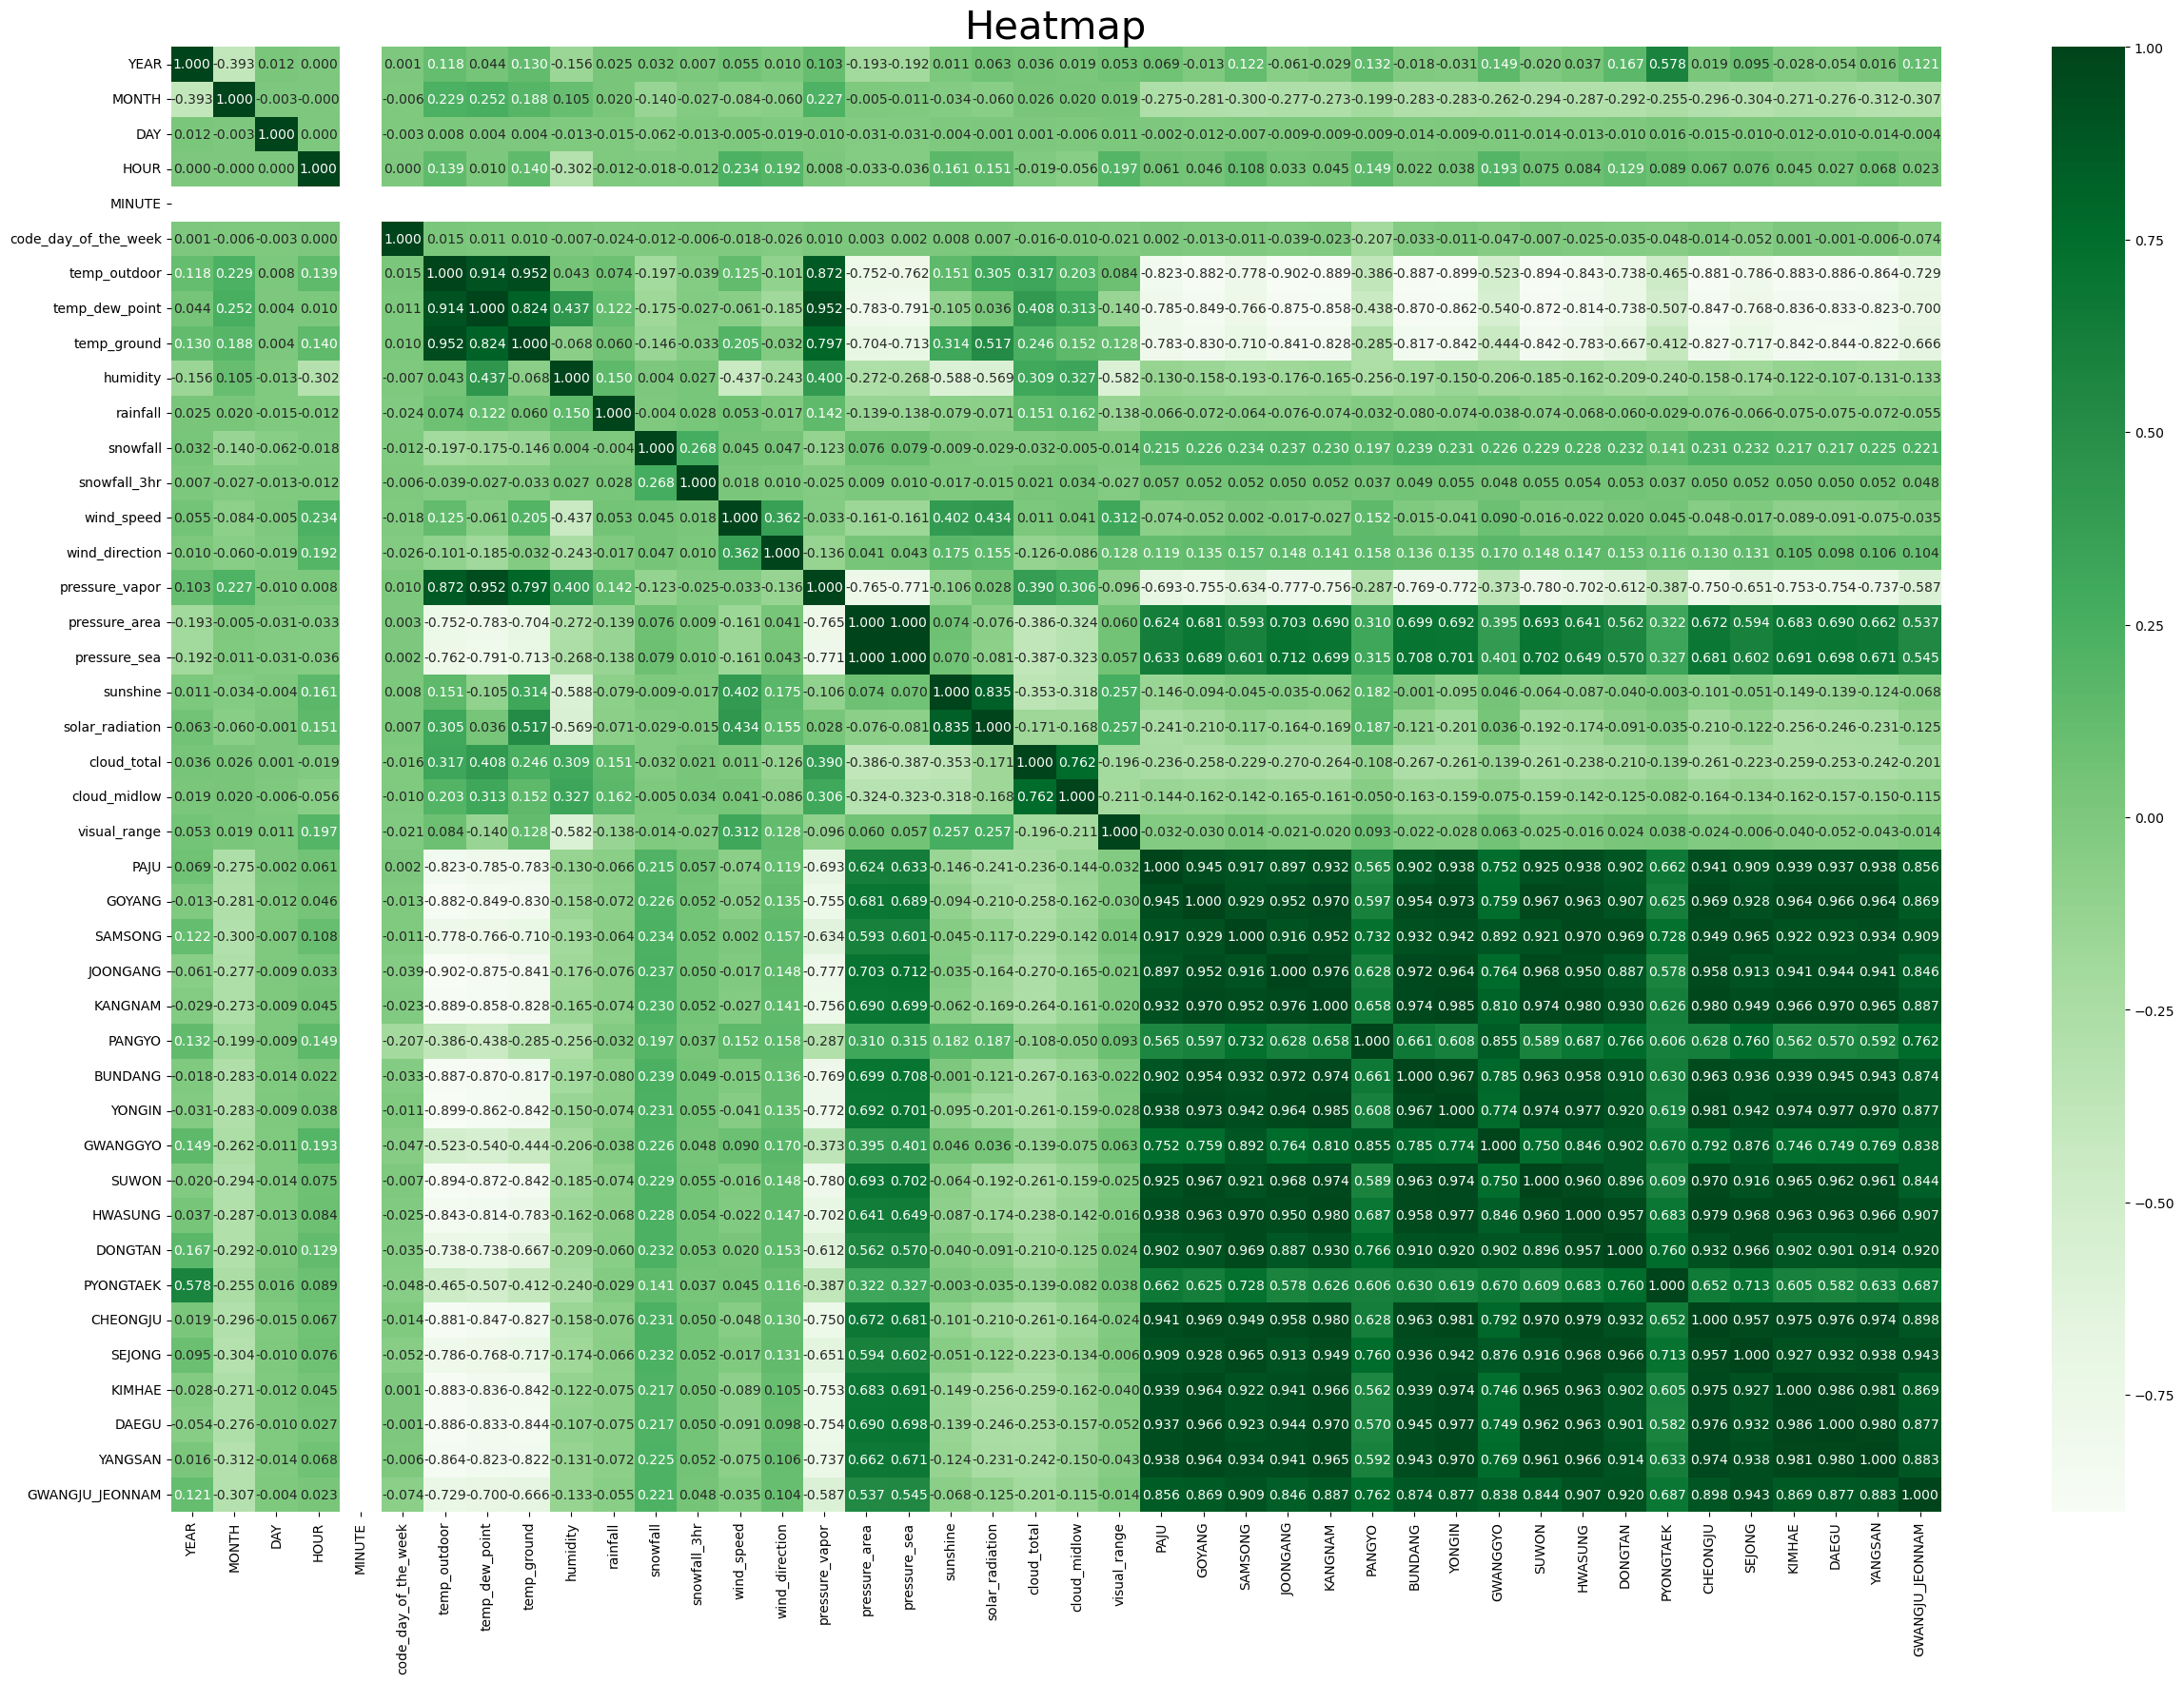

In [12]:
## Heatmap 분석
plt.figure(figsize=(30,20))
ax = sns.heatmap(df_corr, annot=True, fmt='.3f', cmap='Greens')
plt.title("Heatmap", fontsize=30)
plt.show()

In [13]:
df_kdhc_heat.columns

Index(['METER_DATE', 'day_of_the_week', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'MINUTE', 'code_day_of_the_week', 'rest_YN', 'dist_from_holiday',
       'temp_outdoor', 'temp_dew_point', 'temp_ground', 'humidity', 'rainfall',
       'snowfall', 'snowfall_3hr', 'wind_speed', 'wind_direction',
       'pressure_vapor', 'pressure_area', 'pressure_sea', 'sunshine',
       'solar_radiation', 'cloud_total', 'cloud_midlow', 'visual_range',
       'PAJU', 'GOYANG', 'SAMSONG', 'JOONGANG', 'KANGNAM', 'PANGYO', 'BUNDANG',
       'YONGIN', 'GWANGGYO', 'SUWON', 'HWASUNG', 'DONGTAN', 'PYONGTAEK',
       'CHEONGJU', 'SEJONG', 'KIMHAE', 'DAEGU', 'YANGSAN', 'GWANGJU_JEONNAM'],
      dtype='object')

In [14]:
## 상관관계 분석
## 상관관계 변수 생성
df_corr = df_kdhc_heat[['PAJU', 'GOYANG', 'SAMSONG', 'JOONGANG', 'KANGNAM', 'PANGYO', 'BUNDANG', 'YONGIN', 'GWANGGYO', 'SUWON', 'HWASUNG', 'DONGTAN', 'PYONGTAEK', 'CHEONGJU', 'SEJONG', 'KIMHAE', 'DAEGU', 'YANGSAN', 'GWANGJU_JEONNAM']].corr()
df_corr.corr()

,PAJU,GOYANG,SAMSONG,JOONGANG,KANGNAM,PANGYO,BUNDANG,YONGIN,GWANGGYO,SUWON,HWASUNG,DONGTAN,PYONGTAEK,CHEONGJU,SEJONG,KIMHAE,DAEGU,YANGSAN,GWANGJU_JEONNAM
PAJU,1.0000000000,0.9709507319,0.8739542468,0.9127240560,0.9410538155,-0.6904240180,0.9174508897,0.9612949475,-0.1777123493,0.9531395932,0.9498615592,0.7658434529,-0.3924887311,0.9659238035,0.8472100291,0.9714596609,0.9657142403,0.9717175984,0.6493981214
GOYANG,0.9709507319,1.0000000000,0.8834600391,0.9763858295,0.9869475580,-0.6386482145,0.9771819909,0.9954376366,-0.1579158619,0.9929873824,0.9764435041,0.7564703410,-0.5237631316,0.9928501319,0.8726665058,0.9928120234,0.9930864977,0.9919796943,0.6647988303
SAMSONG,0.8739542468,0.8834600391,1.0000000000,0.8701269036,0.9146798639,-0.3169819858,0.8925292257,0.8991220918,0.2724115689,0.8674359108,0.9560598438,0.9607340860,-0.3725051696,0.9119237670,0.9705523565,0.8773883211,0.8845756479,0.8921147356,0.8173993876
JOONGANG,0.9127240560,0.9763858295,0.8701269036,1.0000000000,0.9914094493,-0.5457508125,0.9940546788,0.9843004572,-0.0969535412,0.9873205509,0.9642484931,0.7336319159,-0.6251526115,0.9753615882,0.8661648631,0.9661335526,0.9722604831,0.9642797115,0.6504888725
KANGNAM,0.9410538155,0.9869475580,0.9146798639,0.9914094493,1.0000000000,-0.5353242976,0.9924692005,0.9949322514,-0.0445016603,0.9885086049,0.9887219519,0.7967291079,-0.5815617083,0.9913226344,0.9095929585,0.9811008480,0.9867330441,0.9817051593,0.7075686138
PANGYO,-0.6904240180,-0.6386482145,-0.3169819858,-0.5457508125,-0.5353242976,1.0000000000,-0.5272758267,-0.6055384570,0.7608861325,-0.6408790109,-0.5028541195,-0.1437549911,0.0647746288,-0.5971722434,-0.2501341842,-0.6564832807,-0.6241578909,-0.6389551825,-0.0180138167
BUNDANG,0.9174508897,0.9771819909,0.8925292257,0.9940546788,0.9924692005,-0.5272758267,1.0000000000,0.9860749533,-0.0711583318,0.9840967376,0.9733703608,0.7690123769,-0.5811478325,0.9804764365,0.8928902909,0.9658250170,0.9724088074,0.9666316788,0.6891800085
YONGIN,0.9612949475,0.9954376366,0.8991220918,0.9843004572,0.9949322514,-0.6055384570,0.9860749533,1.0000000000,-0.1186285647,0.9944992313,0.9853465305,0.7762095096,-0.5391031274,0.9967694351,0.8911838322,0.9931210926,0.9949621397,0.9925525981,0.6837285098
GWANGGYO,-0.1777123493,-0.1579158619,0.2724115689,-0.0969535412,-0.0445016603,0.7608861325,-0.0711583318,-0.1186285647,1.0000000000,-0.1732738851,0.0321571213,0.4306627049,-0.0593323170,-0.0990859843,0.2747309763,-0.1698869522,-0.1401605201,-0.1426616262,0.3840881540
SUWON,0.9531395932,0.9929873824,0.8674359108,0.9873205509,0.9885086049,-0.6408790109,0.9840967376,0.9944992313,-0.1732738851,1.0000000000,0.9696072548,0.7302385882,-0.5498724197,0.9886206234,0.8533003426,0.9886230581,0.9882096355,0.9859350754,0.6258856957


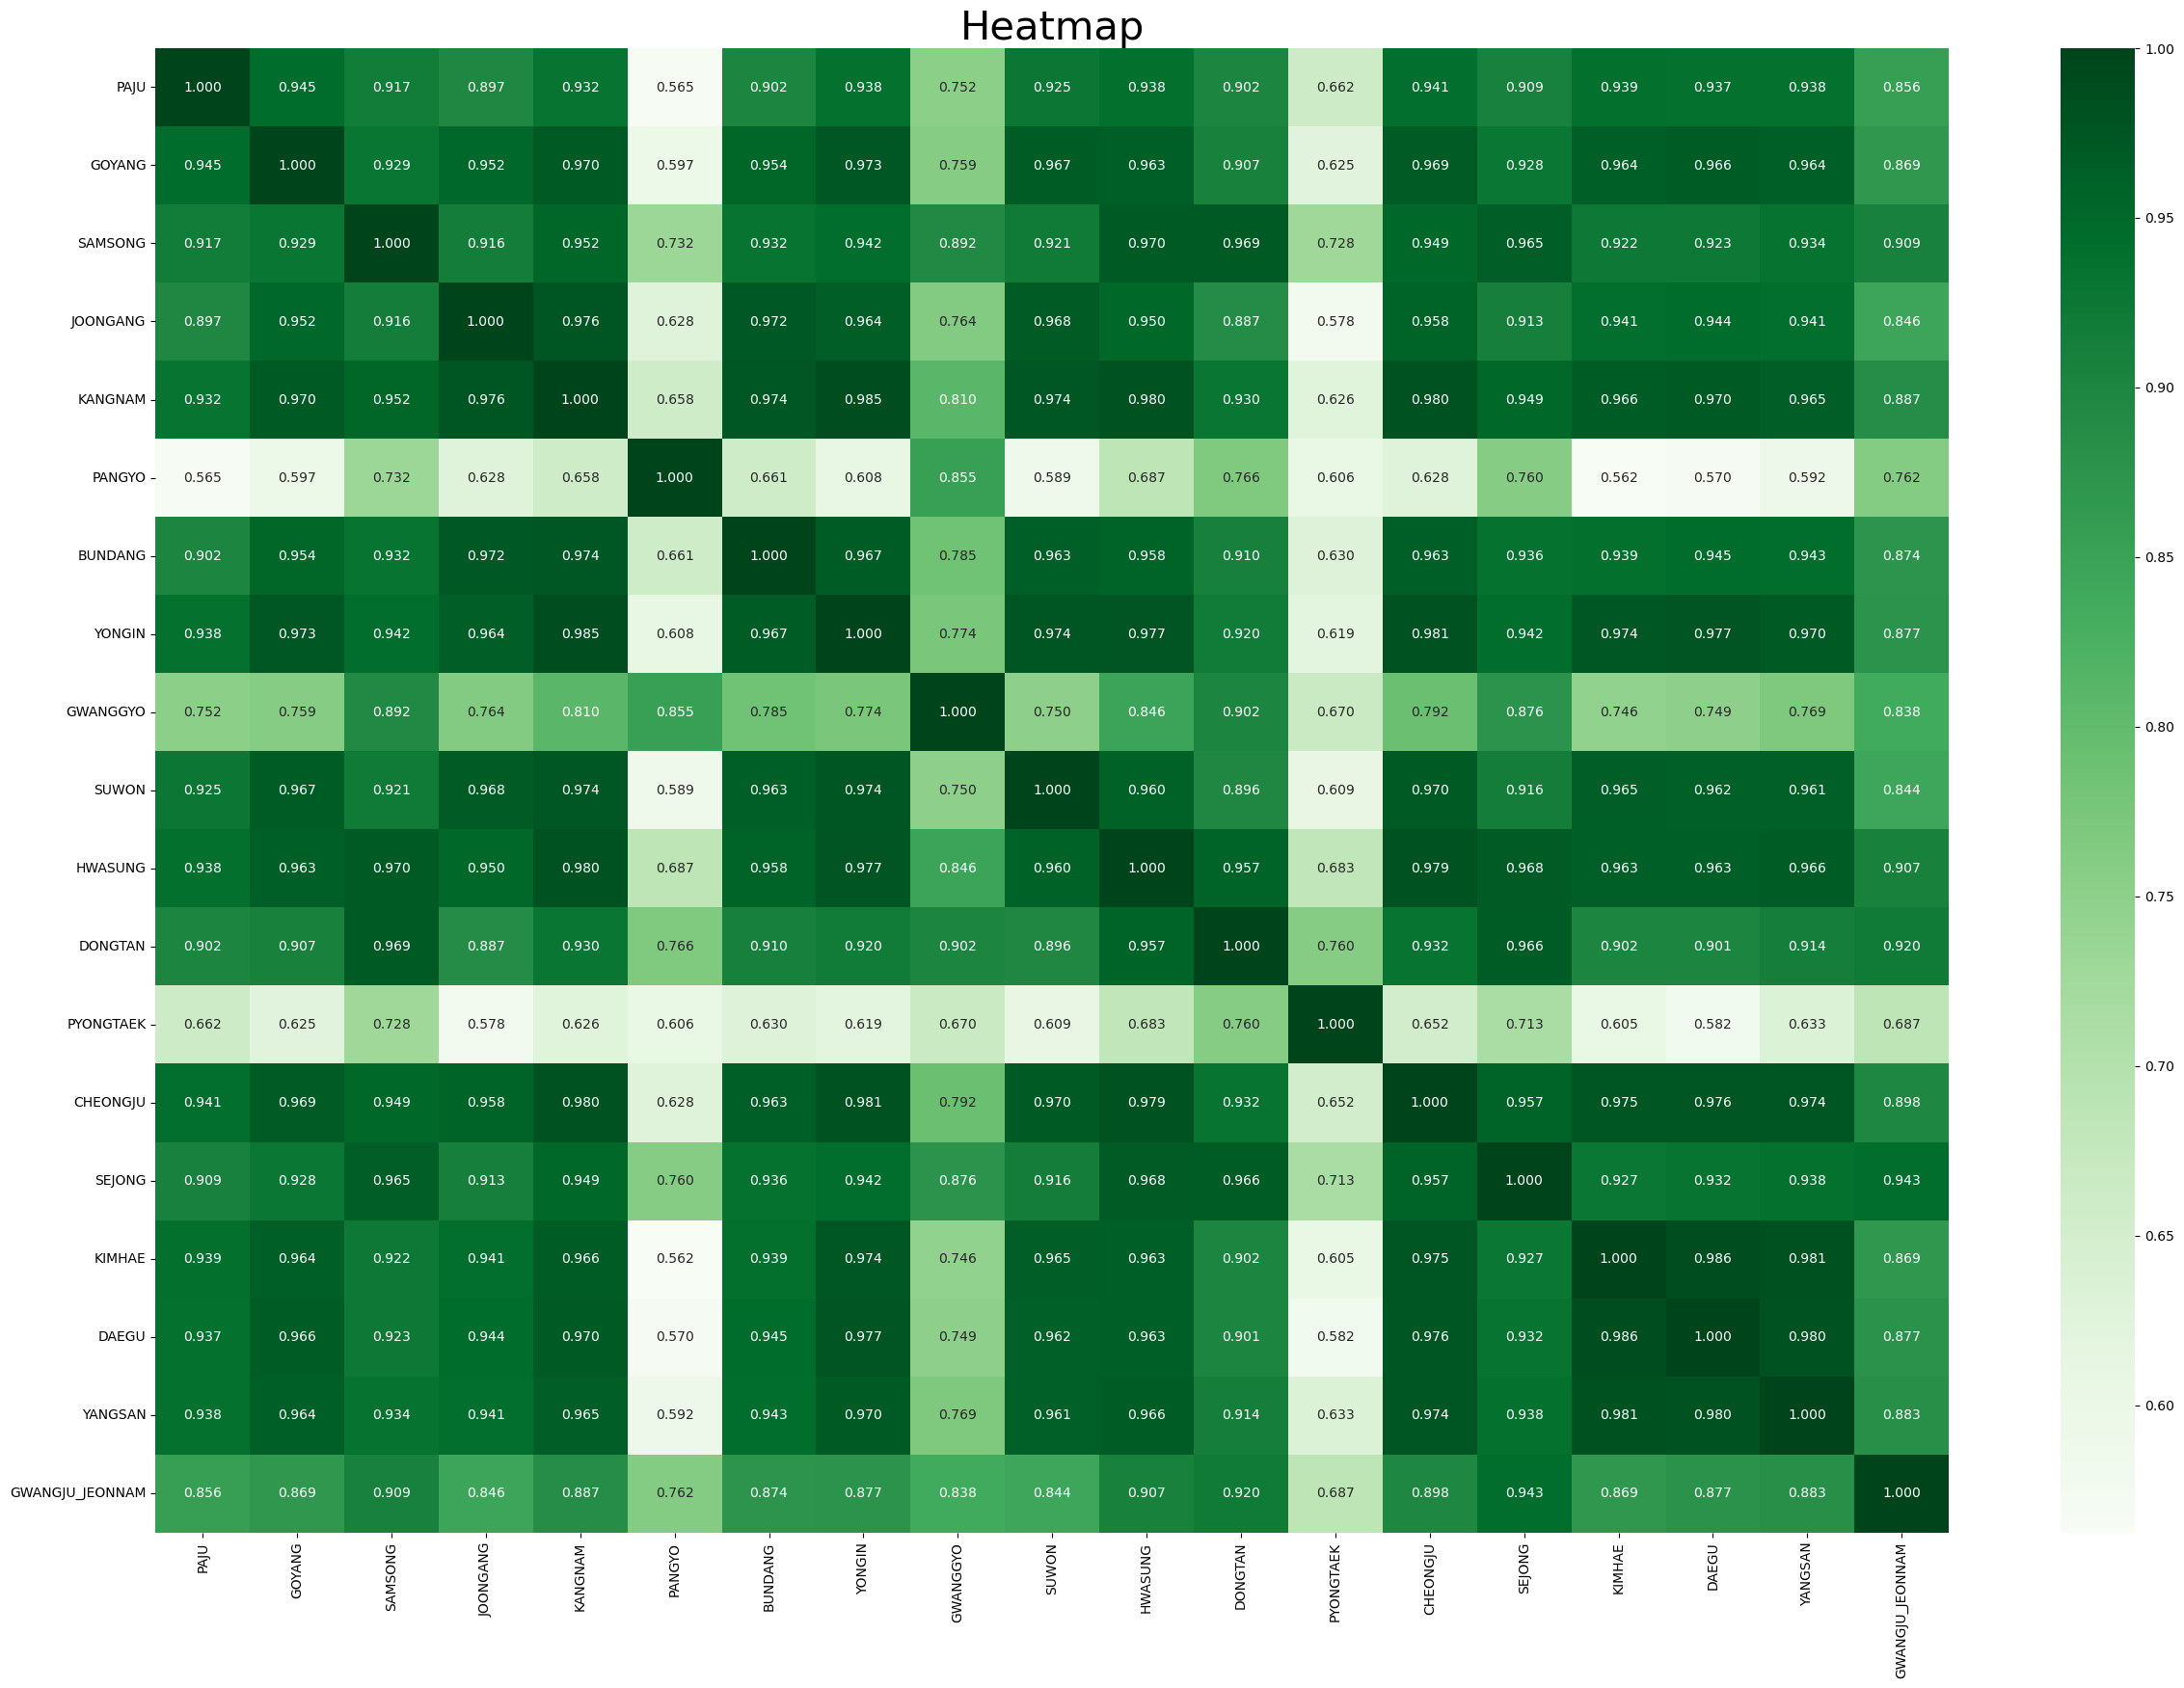

In [15]:
## Heatmap 분석
plt.figure(figsize=(30,20))
ax = sns.heatmap(df_corr, annot=True, fmt='.3f', cmap='Greens')
plt.title("Heatmap", fontsize=30)
plt.show()